# Cifar10 Image Classification with PyTorch
## Table of Contents
* 1. Set up
* 2. Import datasets
* 3. Model Development & Evaluation
* 5. Save the Model
* 6. Load the Model and Make Predictions

## 1. Set up

In [1]:
import torchvision
import torch
import numpy as np
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import time
import pandas as pd
import torchvision.datasets as datasets
from IPython import display
import matplotlib.pyplot as plt

## 2. Import datasets

In [2]:
batch_size = 64
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_ds = DataLoader(datasets.CIFAR10("data", train=True, transform=transform, download=True), batch_size=batch_size)
valid_ds = DataLoader(datasets.CIFAR10("data", train=False, transform=transform, download=True), batch_size=batch_size)

0it [00:00, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


## 3. Model Development & Evaluation

### 3.1 The CNN Model

In [3]:
class CNNModel(nn.Module):
    
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
model = CNNModel(num_classes=10)
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): ReLU()
    (6): Linear(in_fea

### 3.2 Training

In [5]:
def display_message_and_metrics(message, metrics):
    display.clear_output(wait=False) 
    if len(metrics["loss"]) > 0:
        pd.DataFrame(metrics).plot()
        plt.show()
    print(message)

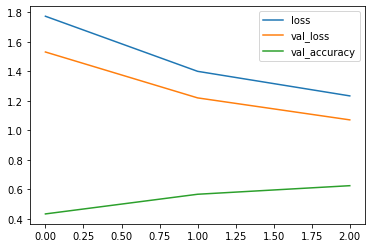

Epoch 4: [Training] 38.49s/50.16s


In [ ]:
epochs = 5
train_steps = len(train_ds)
valid_steps = len(valid_ds)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {"loss": [], "val_loss": [], "val_accuracy": []}
for epoch in range(epochs):
    train_losses = []
    valid_losses = []
    model.train()
    begin = time.time()
    for batch in train_ds:
        optimizer.zero_grad()
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.data.item())
        if len(train_losses) > 0 and len(train_losses) % 50 == 0:
            current = time.time()
            elapsed = current - begin
            display_message_and_metrics(
                "Epoch %d: [Training] %.2fs/%.2fs"%(epoch + 1, elapsed, elapsed / float(len(train_losses)) * train_steps), 
                metrics
            )
    model.eval()
    num_correct = 0
    num_samples = 0
    begin = time.time()
    for batch in valid_ds:
        optimizer.zero_grad()
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)
        valid_losses.append(loss.data.item())
        correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_samples += correct.shape[0]
        if len(valid_losses) > 0 and len(valid_losses) % 50 == 0:
            current = time.time()
            elapsed = current - begin
            display_message_and_metrics(
                "Epoch %d: [Validation] %.2fs/%.2fs"%(epoch + 1, elapsed, elapsed / float(len(valid_losses)) * valid_steps), 
                metrics
            )
    train_loss = torch.mean(torch.Tensor(train_losses)).item()
    valid_loss = torch.mean(torch.Tensor(valid_losses)).item()
    accuracy = num_correct / num_samples if num_samples > 0 else 0
    metrics["loss"].append(train_loss)
    metrics["val_loss"].append(valid_loss)
    metrics["val_accuracy"].append(accuracy)
    display.clear_output(wait=False) 
    pd.DataFrame(metrics).plot()
    plt.show()
    display_message_and_metrics(
        "Training Loss: %.2f Validation Loss: %.2f accuracy: %.2f" %(train_loss, valid_loss, accuracy), 
        metrics
    )

## 4. Save the Model

In [ ]:
path = "model"
torch.save(model, path)

## 5. Load the Model and make predicitons

In [ ]:
model = torch.load(path)
labels = np.array(train_ds.dataset.classes)
for batch in valid_ds:
    images, targets = batch
    images = images.to(device)
    targets = targets.to(device)
    prediction = model(images).argmax(dim=1)
    print("Prediction:", prediction)
    print("Actual result:", targets)
    break